In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!pip install -q tfds-nightly
import tensorflow_datasets as tfds
ds, info = tfds.load('inobus_pet_v4', with_info=True, data_dir='gs://pet_dataset/inobus_pet_v4')

     |████████████████████████████████| 3.9MB 15.2MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras import layers

In [ ]:
train_ds, test_ds = ds['train'], ds['test']

In [ ]:
# tfds.as_dataframe(train_ds.take(10), info)
# tfds.as_dataframe(test_ds.take(10), info)
# fig  = tfds.show_examples(train_ds, info)
# fig  = tfds.show_examples(test_ds, info)

In [ ]:
print(f'Number of classes: {info.features["label"].num_classes}')
print(f'dtypes: {info.features.dtype}')
print(f'Image Shape: {info.features["image"].shape}')

Number of classes: 2
dtypes: {'image': tf.uint8, 'label': tf.int64}
Image Shape: (2464, 3280, 3)


In [ ]:
def insert_history(name, df, his):
  keys = ['val_accuracy', 'val_precision', 'val_recall']
  num_epochs = len(his.history['accuracy']) 
  for i in range(num_epochs - 1, -1, -1):
    df.loc[-1] = [name, i + 1, his.history['val_accuracy'][i],
                       his.history['val_precision'][i], his.history['val_recall'][i]]
    df.index += 1

# Prepare dataset

In [ ]:
@tf.function
def load_image_label(datapoint):
  img = datapoint['image']
  label = datapoint['label']

  return img, label

In [ ]:
train_ds = train_ds.map(load_image_label)
test_ds = test_ds.map(load_image_label)

In [ ]:
def prepare_train_ds(ds):
  batch_size = 32
  buffer_size = 1000

  ds = ds.cache().shuffle(buffer_size).batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

  return ds

In [ ]:
def prepare_test_ds(ds):
  batch_size = 32
  buffer_size = 1000

  ds = ds.cache().batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

  return ds

In [ ]:
def get_ds_with_shape(img_shape):
  """
    img_shape: tuple. e.g. (224, 224, 3)
  """
  resizer = layers.experimental.preprocessing.Resizing(img_shape[0], img_shape[1])
  train = train_ds.map(lambda x, y: (resizer(x), y))
  test= test_ds.map(lambda x, y: (resizer(x), y))

  train = prepare_train_ds(train)
  test = prepare_test_ds(test)

  return train, test


In [ ]:
train_ds_616, test_ds_616 = get_ds_with_shape((616, 616, 3))
train_ds_448, test_ds_448 = get_ds_with_shape((448, 448, 3))
train_ds_224, test_ds_224 = get_ds_with_shape((224, 224, 3))
train_ds_192, test_ds_192 = get_ds_with_shape((192, 192, 3))
train_ds_160, test_ds_160 = get_ds_with_shape((160, 160, 3))
train_ds_128, test_ds_128 = get_ds_with_shape((128, 128, 3))
train_ds_96, test_ds_96 = get_ds_with_shape((96, 96, 3))

# Prepare MobileNet

In [ ]:
def get_mobilenet_with_shape(img_shape, alpha=1.0, dropout=0.001, lr=3e-5):
  inputs = tf.keras.Input(shape=(img_shape))
  x = tf.cast(inputs, tf.float32)
  x = tf.keras.applications.mobilenet.preprocess_input(x)

  mobilenet_base = tf.keras.applications.MobileNet(
      input_shape=img_shape,
      alpha=alpha,
      dropout=dropout,
      include_top=False,
      weights='imagenet'
  )

  x = mobilenet_base(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.Model(inputs, outputs)

  model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
                loss= tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

  return model


## MobileNet V1 224

In [ ]:
img_shape = (224, 224, 3)
mobilenet_224 = get_mobilenet_with_shape(img_shape, alpha=1.0, dropout=0.001)

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
epochs = 40
his_224 = mobilenet_224.fit(train_ds_224, epochs=epochs, validation_data=test_ds_224)

Epoch 1/40
12/12 [==============================] - 86s 3s/step - loss: 0.4994 - accuracy: 0.8681 - precision: 0.8908 - recall: 0.9557 - val_loss: 0.8340 - val_accuracy: 0.7143 - val_precision: 0.7143 - val_recall: 1.0000
Epoch 2/40
12/12 [==============================] - 2s 161ms/step - loss: 0.1274 - accuracy: 0.9947 - precision: 1.0000 - recall: 0.9941 - val_loss: 0.6546 - val_accuracy: 0.7286 - val_precision: 0.7246 - val_recall: 1.0000
Epoch 3/40
12/12 [==============================] - 2s 159ms/step - loss: 0.0745 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5178 - val_accuracy: 0.7786 - val_precision: 0.7634 - val_recall: 1.0000
Epoch 4/40
12/12 [==============================] - 2s 157ms/step - loss: 0.0417 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4305 - val_accuracy: 0.8071 - val_precision: 0.7874 - val_recall: 1.0000
Epoch 5/40
12/12 [==============================] - 2s 158ms/step - loss: 0.0276 - accuracy: 1.0000 - prec

In [ ]:
img_shape = (224, 224, 3)
mobilenet_224_2 = get_mobilenet_with_shape(img_shape, alpha=1.0, dropout=0.1)
epochs = 40
his_224_2 = mobilenet_224_2.fit(train_ds_224, epochs=epochs, validation_data=test_ds_224)

Epoch 1/40
12/12 [==============================] - 5s 210ms/step - loss: 0.5266 - accuracy: 0.7757 - precision: 0.8979 - recall: 0.8346 - val_loss: 0.7116 - val_accuracy: 0.5571 - val_precision: 0.7794 - val_recall: 0.5300
Epoch 2/40
12/12 [==============================] - 2s 157ms/step - loss: 0.1766 - accuracy: 0.9822 - precision: 1.0000 - recall: 0.9792 - val_loss: 0.5554 - val_accuracy: 0.7429 - val_precision: 0.8200 - val_recall: 0.8200
Epoch 3/40
12/12 [==============================] - 2s 155ms/step - loss: 0.0934 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5317 - val_accuracy: 0.7500 - val_precision: 0.8421 - val_recall: 0.8000
Epoch 4/40
12/12 [==============================] - 2s 155ms/step - loss: 0.0467 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5132 - val_accuracy: 0.7643 - val_precision: 0.8681 - val_recall: 0.7900
Epoch 5/40
12/12 [==============================] - 2s 159ms/step - loss: 0.0375 - accuracy: 1.0000 - pr

In [ ]:
img_shape = (224, 224, 3)
mobilenet_224_3 = get_mobilenet_with_shape(img_shape, alpha=1.0, dropout=0.3)
epochs = 40
his_224_3 = mobilenet_224_3.fit(train_ds_224, epochs=epochs, validation_data=test_ds_224)

Epoch 1/40
12/12 [==============================] - 5s 212ms/step - loss: 0.2860 - accuracy: 0.9414 - precision: 0.9479 - recall: 0.9867 - val_loss: 0.7802 - val_accuracy: 0.7143 - val_precision: 0.7143 - val_recall: 1.0000
Epoch 2/40
12/12 [==============================] - 2s 159ms/step - loss: 0.0890 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6723 - val_accuracy: 0.7357 - val_precision: 0.7299 - val_recall: 1.0000
Epoch 3/40
12/12 [==============================] - 2s 155ms/step - loss: 0.0436 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6020 - val_accuracy: 0.7643 - val_precision: 0.7519 - val_recall: 1.0000
Epoch 4/40
12/12 [==============================] - 2s 156ms/step - loss: 0.0272 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5387 - val_accuracy: 0.7929 - val_precision: 0.7752 - val_recall: 1.0000
Epoch 5/40
12/12 [==============================] - 2s 159ms/step - loss: 0.0198 - accuracy: 1.0000 - pr

In [ ]:
img_shape = (224, 224, 3)
mobilenet_224_4 = get_mobilenet_with_shape(img_shape, alpha=0.75, dropout=0.001)
epochs = 40
his_224_4 = mobilenet_224_4.fit(train_ds_224, epochs=epochs, validation_data=test_ds_224)

10633216/10626956 [==============================] - 0s 0us/step
Epoch 1/40
12/12 [==============================] - 5s 208ms/step - loss: 0.3580 - accuracy: 0.8681 - precision: 0.8840 - recall: 0.9747 - val_loss: 0.4425 - val_accuracy: 0.7643 - val_precision: 0.7638 - val_recall: 0.9700
Epoch 2/40
12/12 [==============================] - 2s 131ms/step - loss: 0.1462 - accuracy: 0.9973 - precision: 0.9969 - recall: 1.0000 - val_loss: 0.3883 - val_accuracy: 0.8214 - val_precision: 0.8261 - val_recall: 0.9500
Epoch 3/40
12/12 [==============================] - 2s 127ms/step - loss: 0.0781 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3637 - val_accuracy: 0.8071 - val_precision: 0.8230 - val_recall: 0.9300
Epoch 4/40
12/12 [==============================] - 2s 137ms/step - loss: 0.0475 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3502 - val_accuracy: 0.8000 - val_precision: 0.8214 - val_recall: 0.9200
Epoch 5/40
12/12 [=====================

In [ ]:
img_shape = (224, 224, 3)
mobilenet_224_5 = get_mobilenet_with_shape(img_shape, alpha=0.75, dropout=0.1)
epochs = 40
his_224_5 = mobilenet_224_5.fit(train_ds_224, epochs=epochs, validation_data=test_ds_224)

Epoch 1/40
12/12 [==============================] - 4s 180ms/step - loss: 0.6565 - accuracy: 0.5627 - precision: 0.9928 - recall: 0.5037 - val_loss: 0.4705 - val_accuracy: 0.7929 - val_precision: 0.8737 - val_recall: 0.8300
Epoch 2/40
12/12 [==============================] - 2s 136ms/step - loss: 0.2928 - accuracy: 0.9474 - precision: 1.0000 - recall: 0.9396 - val_loss: 0.4018 - val_accuracy: 0.8286 - val_precision: 0.8800 - val_recall: 0.8800
Epoch 3/40
12/12 [==============================] - 2s 138ms/step - loss: 0.1337 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3644 - val_accuracy: 0.8500 - val_precision: 0.8911 - val_recall: 0.9000
Epoch 4/40
12/12 [==============================] - 2s 133ms/step - loss: 0.1083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3424 - val_accuracy: 0.8429 - val_precision: 0.8900 - val_recall: 0.8900
Epoch 5/40
12/12 [==============================] - 2s 137ms/step - loss: 0.0593 - accuracy: 1.0000 - pr

In [ ]:
img_shape = (224, 224, 3)
mobilenet_224_6 = get_mobilenet_with_shape(img_shape, alpha=0.75, dropout=0.3)
epochs = 40
his_224_6 = mobilenet_224_6.fit(train_ds_224, epochs=epochs, validation_data=test_ds_224)

Epoch 1/40
12/12 [==============================] - 4s 183ms/step - loss: 0.5453 - accuracy: 0.7471 - precision: 0.8822 - recall: 0.7989 - val_loss: 0.5953 - val_accuracy: 0.7143 - val_precision: 0.7143 - val_recall: 1.0000
Epoch 2/40
12/12 [==============================] - 2s 134ms/step - loss: 0.2278 - accuracy: 0.9862 - precision: 1.0000 - recall: 0.9845 - val_loss: 0.4953 - val_accuracy: 0.7143 - val_precision: 0.7143 - val_recall: 1.0000
Epoch 3/40
12/12 [==============================] - 2s 133ms/step - loss: 0.1195 - accuracy: 0.9974 - precision: 1.0000 - recall: 0.9970 - val_loss: 0.4288 - val_accuracy: 0.7643 - val_precision: 0.7519 - val_recall: 1.0000
Epoch 4/40
12/12 [==============================] - 2s 134ms/step - loss: 0.0674 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3724 - val_accuracy: 0.8071 - val_precision: 0.7874 - val_recall: 1.0000
Epoch 5/40
12/12 [==============================] - 2s 133ms/step - loss: 0.0512 - accuracy: 1.0000 - pr

In [ ]:
img_shape = (224, 224, 3)
mobilenet_224_7 = get_mobilenet_with_shape(img_shape, alpha=0.5, dropout=0.001)
epochs = 40
his_224_7 = mobilenet_224_7.fit(train_ds_224, epochs=epochs, validation_data=test_ds_224)

5578752/5577668 [==============================] - 1s 0us/step
Epoch 1/40
12/12 [==============================] - 4s 176ms/step - loss: 0.3779 - accuracy: 0.8674 - precision: 0.8754 - recall: 0.9881 - val_loss: 0.5579 - val_accuracy: 0.7286 - val_precision: 0.7246 - val_recall: 1.0000
Epoch 2/40
12/12 [==============================] - 1s 110ms/step - loss: 0.1875 - accuracy: 0.9448 - precision: 0.9424 - recall: 0.9969 - val_loss: 0.4960 - val_accuracy: 0.7929 - val_precision: 0.7886 - val_recall: 0.9700
Epoch 3/40
12/12 [==============================] - 1s 111ms/step - loss: 0.1066 - accuracy: 0.9836 - precision: 0.9933 - recall: 0.9881 - val_loss: 0.4527 - val_accuracy: 0.8286 - val_precision: 0.8276 - val_recall: 0.9600
Epoch 4/40
12/12 [==============================] - 1s 109ms/step - loss: 0.0777 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4175 - val_accuracy: 0.8786 - val_precision: 0.8807 - val_recall: 0.9600
Epoch 5/40
12/12 [=======================

In [ ]:
img_shape = (224, 224, 3)
mobilenet_224_8 = get_mobilenet_with_shape(img_shape, alpha=0.5, dropout=0.1)
epochs = 40
his_224_8 = mobilenet_224_8.fit(train_ds_224, epochs=epochs, validation_data=test_ds_224)

Epoch 1/40
12/12 [==============================] - 4s 165ms/step - loss: 0.5010 - accuracy: 0.8200 - precision: 0.8808 - recall: 0.9235 - val_loss: 0.7004 - val_accuracy: 0.5214 - val_precision: 0.7037 - val_recall: 0.5700
Epoch 2/40
12/12 [==============================] - 1s 111ms/step - loss: 0.2744 - accuracy: 0.9409 - precision: 0.9443 - recall: 0.9902 - val_loss: 0.6328 - val_accuracy: 0.6143 - val_precision: 0.8026 - val_recall: 0.6100
Epoch 3/40
12/12 [==============================] - 1s 109ms/step - loss: 0.1613 - accuracy: 0.9948 - precision: 0.9940 - recall: 1.0000 - val_loss: 0.5991 - val_accuracy: 0.6929 - val_precision: 0.9014 - val_recall: 0.6400
Epoch 4/40
12/12 [==============================] - 1s 109ms/step - loss: 0.1147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5660 - val_accuracy: 0.7286 - val_precision: 0.9429 - val_recall: 0.6600
Epoch 5/40
12/12 [==============================] - 1s 109ms/step - loss: 0.0916 - accuracy: 1.0000 - pr

In [ ]:
img_shape = (224, 224, 3)
mobilenet_224_9 = get_mobilenet_with_shape(img_shape, alpha=0.5, dropout=0.3)
epochs = 40
his_224_9 = mobilenet_224_9.fit(train_ds_224, epochs=epochs, validation_data=test_ds_224)

Epoch 1/40
12/12 [==============================] - 4s 160ms/step - loss: 1.1622 - accuracy: 0.2259 - precision: 0.8780 - recall: 0.1184 - val_loss: 0.7918 - val_accuracy: 0.3714 - val_precision: 1.0000 - val_recall: 0.1200
Epoch 2/40
12/12 [==============================] - 1s 110ms/step - loss: 0.7371 - accuracy: 0.5171 - precision: 1.0000 - recall: 0.4482 - val_loss: 0.7114 - val_accuracy: 0.4571 - val_precision: 1.0000 - val_recall: 0.2400
Epoch 3/40
12/12 [==============================] - 1s 109ms/step - loss: 0.4321 - accuracy: 0.8354 - precision: 1.0000 - recall: 0.8099 - val_loss: 0.5603 - val_accuracy: 0.6714 - val_precision: 0.9500 - val_recall: 0.5700
Epoch 4/40
12/12 [==============================] - 1s 111ms/step - loss: 0.3132 - accuracy: 0.9318 - precision: 1.0000 - recall: 0.9234 - val_loss: 0.4396 - val_accuracy: 0.8714 - val_precision: 0.9271 - val_recall: 0.8900
Epoch 5/40
12/12 [==============================] - 1s 110ms/step - loss: 0.2020 - accuracy: 0.9943 - pr

In [ ]:
history_224 = pd.DataFrame({
    'name': pd.Series([], dtype='str'),
    'epoch': pd.Series([], dtype='int'),
    'accuracy': pd.Series([], dtype='float'),
    'precision': pd.Series([], dtype='float'),
    'recall': pd.Series([], dtype='float')
})

In [ ]:
insert_history('v1_s=224_a=1.0_d=0.001', history_224, his_224)
insert_history('v1_s=224_a=1.0_d=0.1', history_224, his_224_2)
insert_history('v1_s=224_a=1.0_d=0.3', history_224, his_224_3)
insert_history('v1_s=224_a=0.75_d=0.001', history_224, his_224_4)
insert_history('v1_s=224_a=0.75_d=0.1', history_224, his_224_5)
insert_history('v1_s=224_a=0.75_d=0.3', history_224, his_224_6)
insert_history('v1_s=224_a=0.5_d=0.001', history_224, his_224_7)
insert_history('v1_s=224_a=0.5_d=0.1', history_224, his_224_8)
insert_history('v1_s=224_a=0.5_d=0.3', history_224, his_224_9)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


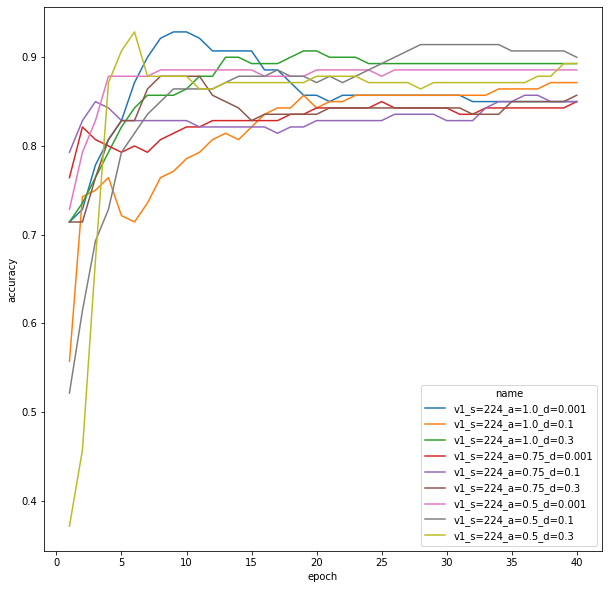

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'accuracy', data=history_224, hue='name')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


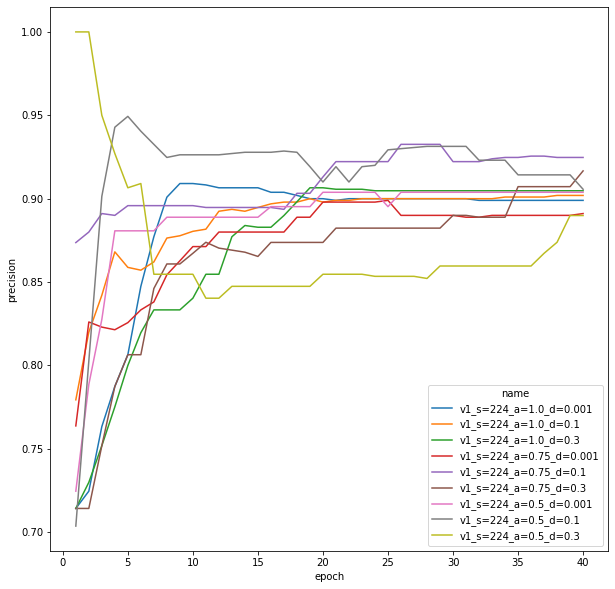

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'precision', data=history_224, hue='name')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


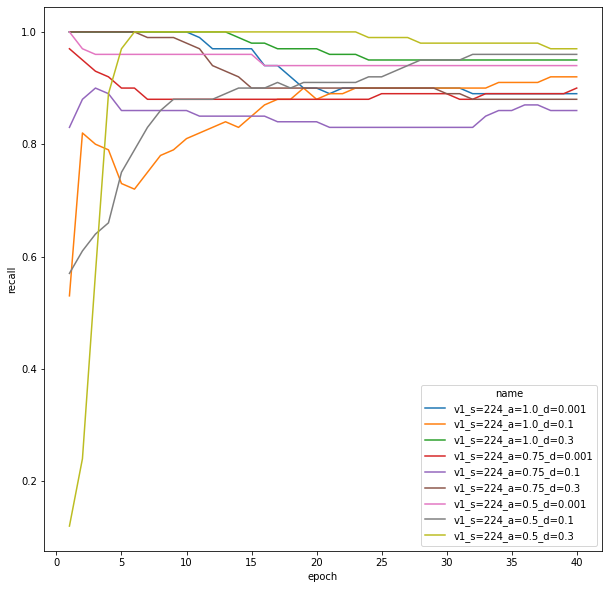

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'recall', data=history_224, hue='name')

## MobileNet V1 616

In [ ]:
# img_shape = (616, 616, 3)
# mobilenet_616 = get_mobilenet_with_shape(img_shape)

# mobilenet_616.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-4),
#                       loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
#                       metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

# epochs = 20
# his_616 = mobilenet_616.fit(train_ds_616, epochs=epochs, validation_data=test_ds_616)

## MobileNet V1 448 

In [ ]:
img_shape = (448, 448, 3)
mobilenet_448 = get_mobilenet_with_shape(img_shape, alpha=1.0, dropout=0.001)
epochs = 40
his_448 = mobilenet_448.fit(train_ds_448, epochs=epochs, validation_data=test_ds_448)

Epoch 1/40
12/12 [==============================] - 65s 3s/step - loss: 0.8499 - accuracy: 0.3397 - precision: 1.0000 - recall: 0.2351 - val_loss: 0.9185 - val_accuracy: 0.3000 - val_precision: 1.0000 - val_recall: 0.0200
Epoch 2/40
12/12 [==============================] - 7s 599ms/step - loss: 0.3065 - accuracy: 0.9464 - precision: 1.0000 - recall: 0.9388 - val_loss: 1.0719 - val_accuracy: 0.2929 - val_precision: 1.0000 - val_recall: 0.0100
Epoch 3/40
12/12 [==============================] - 7s 607ms/step - loss: 0.1429 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1377 - val_accuracy: 0.2929 - val_precision: 1.0000 - val_recall: 0.0100
Epoch 4/40
12/12 [==============================] - 7s 607ms/step - loss: 0.0737 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1468 - val_accuracy: 0.3143 - val_precision: 1.0000 - val_recall: 0.0400
Epoch 5/40
12/12 [==============================] - 7s 595ms/step - loss: 0.0471 - accuracy: 1.0000 - prec

In [ ]:
img_shape = (448, 448, 3)
mobilenet_448_2 = get_mobilenet_with_shape(img_shape, alpha=1.0, dropout=0.1)
epochs = 40
his_448_2 = mobilenet_448_2.fit(train_ds_448, epochs=epochs, validation_data=test_ds_448)

Epoch 1/40
12/12 [==============================] - 10s 642ms/step - loss: 1.0120 - accuracy: 0.2095 - precision: 0.6923 - recall: 0.0909 - val_loss: 1.0938 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
12/12 [==============================] - 7s 588ms/step - loss: 0.4198 - accuracy: 0.8727 - precision: 1.0000 - recall: 0.8548 - val_loss: 1.3949 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
12/12 [==============================] - 7s 598ms/step - loss: 0.1942 - accuracy: 0.9871 - precision: 1.0000 - recall: 0.9857 - val_loss: 1.6548 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
12/12 [==============================] - 7s 593ms/step - loss: 0.1006 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.7692 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/40
12/12 [==============================] - 7s 607ms/step - los

In [ ]:
img_shape = (448, 448, 3)
mobilenet_448_3 = get_mobilenet_with_shape(img_shape, alpha=1.0, dropout=0.3)
epochs = 40
his_448_3 = mobilenet_448_3.fit(train_ds_448, epochs=epochs, validation_data=test_ds_448)

Epoch 1/40
12/12 [==============================] - 10s 643ms/step - loss: 1.0134 - accuracy: 0.1985 - precision: 0.8462 - recall: 0.0949 - val_loss: 0.9903 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
12/12 [==============================] - 7s 609ms/step - loss: 0.3390 - accuracy: 0.9539 - precision: 1.0000 - recall: 0.9456 - val_loss: 0.9918 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
12/12 [==============================] - 7s 591ms/step - loss: 0.1661 - accuracy: 0.9947 - precision: 1.0000 - recall: 0.9941 - val_loss: 1.0159 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
12/12 [==============================] - 7s 601ms/step - loss: 0.0840 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.8911 - val_accuracy: 0.3786 - val_precision: 1.0000 - val_recall: 0.1300
Epoch 5/40
12/12 [==============================] - 7s 585ms/step - loss: 0.050

In [ ]:
img_shape = (448, 448, 3)
mobilenet_448_4 = get_mobilenet_with_shape(img_shape, alpha=0.75, dropout=0.001)
epochs = 40
his_448_4 = mobilenet_448_4.fit(train_ds_448, epochs=epochs, validation_data=test_ds_448)

Epoch 1/40
12/12 [==============================] - 10s 593ms/step - loss: 1.3905 - accuracy: 0.1262 - precision: 0.2308 - recall: 0.0026 - val_loss: 1.8164 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
12/12 [==============================] - 6s 489ms/step - loss: 0.7131 - accuracy: 0.4478 - precision: 1.0000 - recall: 0.3573 - val_loss: 1.8874 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
12/12 [==============================] - 6s 480ms/step - loss: 0.4477 - accuracy: 0.8693 - precision: 1.0000 - recall: 0.8577 - val_loss: 2.1251 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
12/12 [==============================] - 6s 490ms/step - loss: 0.2019 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.1779 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/40
12/12 [==============================] - 6s 498ms/step - los

In [ ]:
img_shape = (448, 448, 3)
mobilenet_448_5 = get_mobilenet_with_shape(img_shape, alpha=0.75, dropout=0.1)
epochs = 40
his_448_5 = mobilenet_448_5.fit(train_ds_448, epochs=epochs, validation_data=test_ds_448)

Epoch 1/40
12/12 [==============================] - 9s 539ms/step - loss: 0.5004 - accuracy: 0.8661 - precision: 0.8999 - recall: 0.9541 - val_loss: 0.5424 - val_accuracy: 0.8500 - val_precision: 0.9247 - val_recall: 0.8600
Epoch 2/40
12/12 [==============================] - 6s 498ms/step - loss: 0.2389 - accuracy: 0.9941 - precision: 0.9932 - recall: 1.0000 - val_loss: 0.4715 - val_accuracy: 0.8429 - val_precision: 0.8980 - val_recall: 0.8800
Epoch 3/40
12/12 [==============================] - 6s 480ms/step - loss: 0.1340 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4433 - val_accuracy: 0.8429 - val_precision: 0.8980 - val_recall: 0.8800
Epoch 4/40
12/12 [==============================] - 6s 514ms/step - loss: 0.0813 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4173 - val_accuracy: 0.8429 - val_precision: 0.8980 - val_recall: 0.8800
Epoch 5/40
12/12 [==============================] - 6s 499ms/step - loss: 0.0601 - accuracy: 1.0000 - pr

In [ ]:
img_shape = (448, 448, 3)
mobilenet_448_6 = get_mobilenet_with_shape(img_shape, alpha=0.75, dropout=0.3)
epochs = 40
his_448_6 = mobilenet_448_6.fit(train_ds_448, epochs=epochs, validation_data=test_ds_448)

Epoch 1/40
12/12 [==============================] - 9s 544ms/step - loss: 0.4813 - accuracy: 0.8269 - precision: 0.9040 - recall: 0.8970 - val_loss: 0.5612 - val_accuracy: 0.7786 - val_precision: 0.7760 - val_recall: 0.9700
Epoch 2/40
12/12 [==============================] - 6s 495ms/step - loss: 0.2318 - accuracy: 0.9888 - precision: 0.9874 - recall: 1.0000 - val_loss: 0.4780 - val_accuracy: 0.8500 - val_precision: 0.8319 - val_recall: 0.9900
Epoch 3/40
12/12 [==============================] - 6s 510ms/step - loss: 0.1322 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4207 - val_accuracy: 0.8429 - val_precision: 0.8305 - val_recall: 0.9800
Epoch 4/40
12/12 [==============================] - 6s 497ms/step - loss: 0.0822 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3803 - val_accuracy: 0.8429 - val_precision: 0.8305 - val_recall: 0.9800
Epoch 5/40
12/12 [==============================] - 6s 480ms/step - loss: 0.0576 - accuracy: 1.0000 - pr

In [ ]:
img_shape = (448, 448, 3)
mobilenet_448_7 = get_mobilenet_with_shape(img_shape, alpha=0.5, dropout=0.001)
epochs = 40
his_448_7 = mobilenet_448_7.fit(train_ds_448, epochs=epochs, validation_data=test_ds_448)

Epoch 1/40
12/12 [==============================] - 8s 475ms/step - loss: 0.3912 - accuracy: 0.8915 - precision: 0.8915 - recall: 1.0000 - val_loss: 0.5502 - val_accuracy: 0.7571 - val_precision: 0.7538 - val_recall: 0.9800
Epoch 2/40
12/12 [==============================] - 5s 401ms/step - loss: 0.2576 - accuracy: 0.9225 - precision: 0.9189 - recall: 1.0000 - val_loss: 0.5590 - val_accuracy: 0.8214 - val_precision: 0.9213 - val_recall: 0.8200
Epoch 3/40
12/12 [==============================] - 5s 400ms/step - loss: 0.1633 - accuracy: 0.9883 - precision: 0.9870 - recall: 1.0000 - val_loss: 0.5685 - val_accuracy: 0.7786 - val_precision: 0.9726 - val_recall: 0.7100
Epoch 4/40
12/12 [==============================] - 5s 398ms/step - loss: 0.1141 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5686 - val_accuracy: 0.7571 - val_precision: 0.9714 - val_recall: 0.6800
Epoch 5/40
12/12 [==============================] - 5s 392ms/step - loss: 0.0949 - accuracy: 1.0000 - pr

In [ ]:
img_shape = (448, 448, 3)
mobilenet_448_8 = get_mobilenet_with_shape(img_shape, alpha=0.5, dropout=0.1)
epochs = 40
his_448_8 = mobilenet_448_8.fit(train_ds_448, epochs=epochs, validation_data=test_ds_448)

Epoch 1/40
12/12 [==============================] - 8s 457ms/step - loss: 0.6553 - accuracy: 0.6537 - precision: 0.8492 - recall: 0.7069 - val_loss: 0.9322 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
12/12 [==============================] - 5s 405ms/step - loss: 0.3844 - accuracy: 0.9665 - precision: 0.9668 - recall: 0.9952 - val_loss: 0.9848 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
12/12 [==============================] - 5s 406ms/step - loss: 0.2562 - accuracy: 0.9948 - precision: 0.9971 - recall: 0.9970 - val_loss: 1.0057 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
12/12 [==============================] - 5s 411ms/step - loss: 0.1771 - accuracy: 0.9947 - precision: 0.9941 - recall: 1.0000 - val_loss: 0.9591 - val_accuracy: 0.3143 - val_precision: 1.0000 - val_recall: 0.0400
Epoch 5/40
12/12 [==============================] - 5s 403ms/step - loss: 0.1274

In [ ]:
img_shape = (448, 448, 3)
mobilenet_448_9 = get_mobilenet_with_shape(img_shape, alpha=0.5, dropout=0.3)
epochs = 40
his_448_9 = mobilenet_448_9.fit(train_ds_448, epochs=epochs, validation_data=test_ds_448)

Epoch 1/40
12/12 [==============================] - 7s 445ms/step - loss: 0.7377 - accuracy: 0.4695 - precision: 0.9585 - recall: 0.3937 - val_loss: 0.9162 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
12/12 [==============================] - 5s 397ms/step - loss: 0.4619 - accuracy: 0.9199 - precision: 0.9885 - recall: 0.9159 - val_loss: 1.0107 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
12/12 [==============================] - 5s 397ms/step - loss: 0.3102 - accuracy: 0.9953 - precision: 0.9959 - recall: 0.9987 - val_loss: 1.0864 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
12/12 [==============================] - 5s 404ms/step - loss: 0.2209 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1062 - val_accuracy: 0.2929 - val_precision: 1.0000 - val_recall: 0.0100
Epoch 5/40
12/12 [==============================] - 5s 407ms/step - loss: 0.1564

In [ ]:
history_448 = pd.DataFrame({
    'name': pd.Series([], dtype='str'),
    'epoch': pd.Series([], dtype='int'),
    'accuracy': pd.Series([], dtype='float'),
    'precision': pd.Series([], dtype='float'),
    'recall': pd.Series([], dtype='float')
})

insert_history('v1_s=448_a=1.0_d=0.001', history_448, his_448)
insert_history('v1_s=448_a=1.0_d=0.1', history_448, his_448_2)
insert_history('v1_s=448_a=1.0_d=0.3', history_448, his_448_3)
insert_history('v1_s=448_a=0.75_d=0.001', history_448, his_448_4)
insert_history('v1_s=448_a=0.75_d=0.1', history_448, his_448_5)
insert_history('v1_s=448_a=0.75_d=0.3', history_448, his_448_6)
insert_history('v1_s=448_a=0.5_d=0.001', history_448, his_448_7)
insert_history('v1_s=448_a=0.5_d=0.1', history_448, his_448_8)
insert_history('v1_s=448_a=0.5_d=0.3', history_448, his_448_9)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


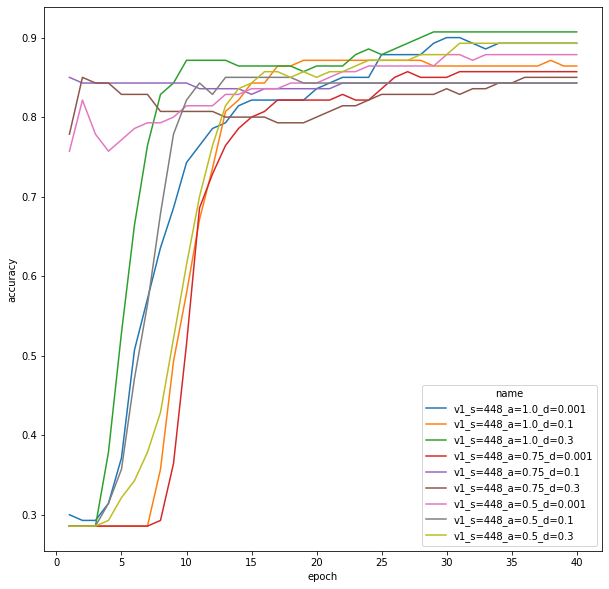

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'accuracy', data=history_448, hue='name')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


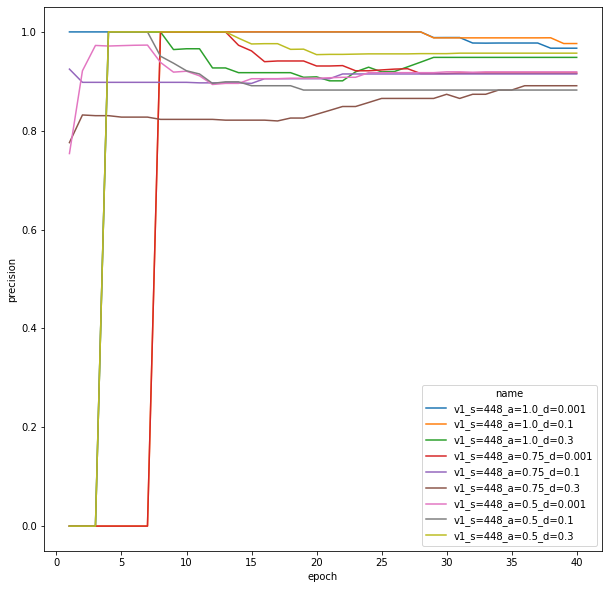

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'precision', data=history_448, hue='name')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


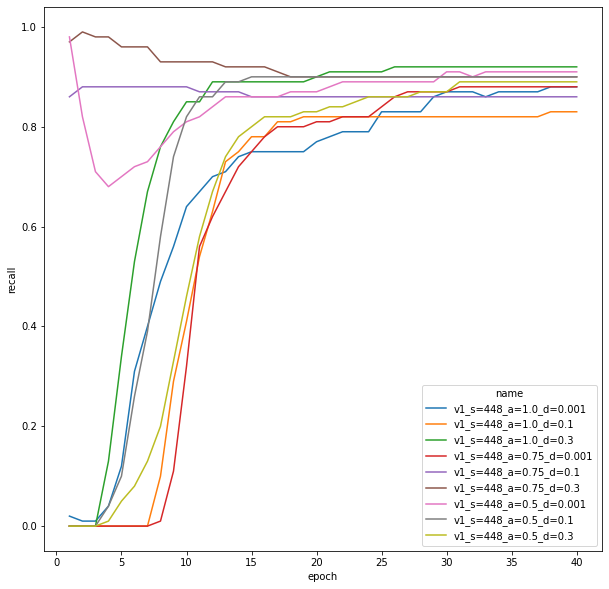

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'recall', data=history_448, hue='name')

## MobileNet V1 192

In [ ]:
img_shape = (192, 192, 3)
mobilenet_192 = get_mobilenet_with_shape(img_shape, alpha=1.0, dropout=0.001)
epochs = 40
his_192 = mobilenet_192.fit(train_ds_192, epochs=epochs, validation_data=test_ds_192)

17227776/17225924 [==============================] - 1s 0us/step
Epoch 1/40
12/12 [==============================] - 49s 2s/step - loss: 0.4986 - accuracy: 0.8154 - precision: 0.9138 - recall: 0.8690 - val_loss: 0.5445 - val_accuracy: 0.7500 - val_precision: 0.8652 - val_recall: 0.7700
Epoch 2/40
12/12 [==============================] - 1s 120ms/step - loss: 0.1535 - accuracy: 0.9871 - precision: 1.0000 - recall: 0.9852 - val_loss: 0.4004 - val_accuracy: 0.8500 - val_precision: 0.8911 - val_recall: 0.9000
Epoch 3/40
12/12 [==============================] - 1s 122ms/step - loss: 0.0649 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3315 - val_accuracy: 0.8929 - val_precision: 0.9048 - val_recall: 0.9500
Epoch 4/40
12/12 [==============================] - 1s 122ms/step - loss: 0.0550 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2959 - val_accuracy: 0.9071 - val_precision: 0.8991 - val_recall: 0.9800
Epoch 5/40
12/12 [=======================

In [ ]:
img_shape = (192, 192, 3)
mobilenet_192_2 = get_mobilenet_with_shape(img_shape, alpha=1.0, dropout=0.1)
epochs = 40
his_192_2 = mobilenet_192_2.fit(train_ds_192, epochs=epochs, validation_data=test_ds_192)

Epoch 1/40
12/12 [==============================] - 4s 170ms/step - loss: 1.3761 - accuracy: 0.2135 - precision: 1.0000 - recall: 0.1219 - val_loss: 0.6440 - val_accuracy: 0.5500 - val_precision: 0.9302 - val_recall: 0.4000
Epoch 2/40
12/12 [==============================] - 1s 121ms/step - loss: 0.5512 - accuracy: 0.7435 - precision: 1.0000 - recall: 0.7037 - val_loss: 0.5209 - val_accuracy: 0.7786 - val_precision: 0.9859 - val_recall: 0.7000
Epoch 3/40
12/12 [==============================] - 1s 120ms/step - loss: 0.2691 - accuracy: 0.9467 - precision: 1.0000 - recall: 0.9397 - val_loss: 0.4339 - val_accuracy: 0.8786 - val_precision: 0.9882 - val_recall: 0.8400
Epoch 4/40
12/12 [==============================] - 1s 122ms/step - loss: 0.1128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3762 - val_accuracy: 0.8714 - val_precision: 0.9659 - val_recall: 0.8500
Epoch 5/40
12/12 [==============================] - 1s 122ms/step - loss: 0.0664 - accuracy: 1.0000 - pr

In [ ]:
img_shape = (192, 192, 3)
mobilenet_192_3 = get_mobilenet_with_shape(img_shape, alpha=1.0, dropout=0.3)
epochs = 40
his_192_3 = mobilenet_192_3.fit(train_ds_192, epochs=epochs, validation_data=test_ds_192)

Epoch 1/40
12/12 [==============================] - 4s 169ms/step - loss: 0.3586 - accuracy: 0.8725 - precision: 0.9666 - recall: 0.8867 - val_loss: 0.4176 - val_accuracy: 0.8214 - val_precision: 0.8378 - val_recall: 0.9300
Epoch 2/40
12/12 [==============================] - 1s 118ms/step - loss: 0.1098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3211 - val_accuracy: 0.8786 - val_precision: 0.9029 - val_recall: 0.9300
Epoch 3/40
12/12 [==============================] - 1s 117ms/step - loss: 0.0632 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2577 - val_accuracy: 0.9071 - val_precision: 0.9065 - val_recall: 0.9700
Epoch 4/40
12/12 [==============================] - 1s 118ms/step - loss: 0.0310 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2313 - val_accuracy: 0.9071 - val_precision: 0.9065 - val_recall: 0.9700
Epoch 5/40
12/12 [==============================] - 1s 118ms/step - loss: 0.0264 - accuracy: 1.0000 - pr

In [ ]:
img_shape = (192, 192, 3)
mobilenet_192_4 = get_mobilenet_with_shape(img_shape, alpha=0.75, dropout=0.001)
epochs = 40
his_192_4 = mobilenet_192_4.fit(train_ds_192, epochs=epochs, validation_data=test_ds_192)

10633216/10626956 [==============================] - 0s 0us/step
Epoch 1/40
12/12 [==============================] - 4s 172ms/step - loss: 1.5849 - accuracy: 0.1397 - precision: 0.7520 - recall: 0.0293 - val_loss: 0.7537 - val_accuracy: 0.4714 - val_precision: 0.8421 - val_recall: 0.3200
Epoch 2/40
12/12 [==============================] - 1s 106ms/step - loss: 0.9033 - accuracy: 0.3769 - precision: 1.0000 - recall: 0.2957 - val_loss: 0.5941 - val_accuracy: 0.6286 - val_precision: 0.9138 - val_recall: 0.5300
Epoch 3/40
12/12 [==============================] - 1s 98ms/step - loss: 0.4650 - accuracy: 0.7668 - precision: 1.0000 - recall: 0.7295 - val_loss: 0.4157 - val_accuracy: 0.8571 - val_precision: 0.9082 - val_recall: 0.8900
Epoch 4/40
12/12 [==============================] - 1s 104ms/step - loss: 0.2760 - accuracy: 0.9376 - precision: 1.0000 - recall: 0.9288 - val_loss: 0.3334 - val_accuracy: 0.9000 - val_precision: 0.8909 - val_recall: 0.9800
Epoch 5/40
12/12 [======================

In [ ]:
img_shape = (192, 192, 3)
mobilenet_192_5 = get_mobilenet_with_shape(img_shape, alpha=0.75, dropout=0.1)
epochs = 40
his_192_5 = mobilenet_192_5.fit(train_ds_192, epochs=epochs, validation_data=test_ds_192)

Epoch 1/40
12/12 [==============================] - 4s 155ms/step - loss: 0.5319 - accuracy: 0.7853 - precision: 0.9251 - recall: 0.8294 - val_loss: 0.4784 - val_accuracy: 0.8429 - val_precision: 0.8482 - val_recall: 0.9500
Epoch 2/40
12/12 [==============================] - 1s 98ms/step - loss: 0.2341 - accuracy: 0.9641 - precision: 1.0000 - recall: 0.9589 - val_loss: 0.3935 - val_accuracy: 0.8643 - val_precision: 0.8522 - val_recall: 0.9800
Epoch 3/40
12/12 [==============================] - 1s 102ms/step - loss: 0.1268 - accuracy: 0.9952 - precision: 1.0000 - recall: 0.9946 - val_loss: 0.3554 - val_accuracy: 0.8571 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 4/40
12/12 [==============================] - 1s 106ms/step - loss: 0.0755 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3487 - val_accuracy: 0.8571 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 5/40
12/12 [==============================] - 1s 96ms/step - loss: 0.0511 - accuracy: 1.0000 - prec

In [ ]:
img_shape = (192, 192, 3)
mobilenet_192_6 = get_mobilenet_with_shape(img_shape, alpha=0.75, dropout=0.3)
epochs = 40
his_192_6 = mobilenet_192_6.fit(train_ds_192, epochs=epochs, validation_data=test_ds_192)

Epoch 1/40
12/12 [==============================] - 4s 147ms/step - loss: 0.9938 - accuracy: 0.3193 - precision: 0.9283 - recall: 0.2218 - val_loss: 0.6467 - val_accuracy: 0.6357 - val_precision: 0.8657 - val_recall: 0.5800
Epoch 2/40
12/12 [==============================] - 1s 100ms/step - loss: 0.4384 - accuracy: 0.8278 - precision: 1.0000 - recall: 0.7965 - val_loss: 0.5451 - val_accuracy: 0.7143 - val_precision: 0.8659 - val_recall: 0.7100
Epoch 3/40
12/12 [==============================] - 1s 102ms/step - loss: 0.2401 - accuracy: 0.9763 - precision: 1.0000 - recall: 0.9728 - val_loss: 0.4352 - val_accuracy: 0.8429 - val_precision: 0.8900 - val_recall: 0.8900
Epoch 4/40
12/12 [==============================] - 1s 99ms/step - loss: 0.1631 - accuracy: 0.9885 - precision: 0.9993 - recall: 0.9879 - val_loss: 0.3816 - val_accuracy: 0.8571 - val_precision: 0.8571 - val_recall: 0.9600
Epoch 5/40
12/12 [==============================] - 1s 102ms/step - loss: 0.0773 - accuracy: 1.0000 - pre

In [ ]:
img_shape = (192, 192, 3)
mobilenet_192_7 = get_mobilenet_with_shape(img_shape, alpha=0.5, dropout=0.001)
epochs = 40
his_192_7 = mobilenet_192_7.fit(train_ds_192, epochs=epochs, validation_data=test_ds_192)

5578752/5577668 [==============================] - 0s 0us/step
Epoch 1/40
12/12 [==============================] - 5s 148ms/step - loss: 0.6693 - accuracy: 0.5979 - precision: 0.9474 - recall: 0.5790 - val_loss: 0.7426 - val_accuracy: 0.4286 - val_precision: 0.7500 - val_recall: 0.3000
Epoch 2/40
12/12 [==============================] - 1s 85ms/step - loss: 0.3589 - accuracy: 0.8977 - precision: 0.9933 - recall: 0.8898 - val_loss: 0.6219 - val_accuracy: 0.6643 - val_precision: 0.8630 - val_recall: 0.6300
Epoch 3/40
12/12 [==============================] - 1s 85ms/step - loss: 0.2178 - accuracy: 0.9692 - precision: 1.0000 - recall: 0.9645 - val_loss: 0.5369 - val_accuracy: 0.7643 - val_precision: 0.8851 - val_recall: 0.7700
Epoch 4/40
12/12 [==============================] - 1s 84ms/step - loss: 0.1528 - accuracy: 0.9902 - precision: 1.0000 - recall: 0.9890 - val_loss: 0.4699 - val_accuracy: 0.8143 - val_precision: 0.8854 - val_recall: 0.8500
Epoch 5/40
12/12 [==========================

In [ ]:
img_shape = (192, 192, 3)
mobilenet_192_8 = get_mobilenet_with_shape(img_shape, alpha=0.5, dropout=0.1)
epochs = 40
his_192_8 = mobilenet_192_8.fit(train_ds_192, epochs=epochs, validation_data=test_ds_192)

Epoch 1/40
12/12 [==============================] - 4s 136ms/step - loss: 0.3407 - accuracy: 0.8426 - precision: 0.9050 - recall: 0.9215 - val_loss: 0.6519 - val_accuracy: 0.7143 - val_precision: 0.7143 - val_recall: 1.0000
Epoch 2/40
12/12 [==============================] - 1s 84ms/step - loss: 0.1773 - accuracy: 0.9744 - precision: 0.9803 - recall: 0.9904 - val_loss: 0.6250 - val_accuracy: 0.7214 - val_precision: 0.7194 - val_recall: 1.0000
Epoch 3/40
12/12 [==============================] - 1s 85ms/step - loss: 0.1042 - accuracy: 0.9941 - precision: 1.0000 - recall: 0.9932 - val_loss: 0.5855 - val_accuracy: 0.7714 - val_precision: 0.7576 - val_recall: 1.0000
Epoch 4/40
12/12 [==============================] - 1s 85ms/step - loss: 0.0696 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5537 - val_accuracy: 0.8429 - val_precision: 0.8197 - val_recall: 1.0000
Epoch 5/40
12/12 [==============================] - 1s 84ms/step - loss: 0.0463 - accuracy: 1.0000 - precis

In [ ]:
img_shape = (192, 192, 3)
mobilenet_192_9 = get_mobilenet_with_shape(img_shape, alpha=0.5, dropout=0.3)
epochs = 40
his_192_9 = mobilenet_192_9.fit(train_ds_192, epochs=epochs, validation_data=test_ds_192)

Epoch 1/40
12/12 [==============================] - 4s 133ms/step - loss: 0.6562 - accuracy: 0.6166 - precision: 0.8494 - recall: 0.6738 - val_loss: 0.5924 - val_accuracy: 0.7143 - val_precision: 0.7143 - val_recall: 1.0000
Epoch 2/40
12/12 [==============================] - 1s 83ms/step - loss: 0.3395 - accuracy: 0.9168 - precision: 0.9902 - recall: 0.9124 - val_loss: 0.5379 - val_accuracy: 0.7214 - val_precision: 0.7194 - val_recall: 1.0000
Epoch 3/40
12/12 [==============================] - 1s 84ms/step - loss: 0.2025 - accuracy: 0.9721 - precision: 1.0000 - recall: 0.9684 - val_loss: 0.5048 - val_accuracy: 0.7429 - val_precision: 0.7353 - val_recall: 1.0000
Epoch 4/40
12/12 [==============================] - 1s 83ms/step - loss: 0.1371 - accuracy: 0.9871 - precision: 1.0000 - recall: 0.9855 - val_loss: 0.4820 - val_accuracy: 0.7786 - val_precision: 0.7634 - val_recall: 1.0000
Epoch 5/40
12/12 [==============================] - 1s 84ms/step - loss: 0.0924 - accuracy: 1.0000 - precis

In [ ]:
history_192 = pd.DataFrame({
    'name': pd.Series([], dtype='str'),
    'epoch': pd.Series([], dtype='int'),
    'accuracy': pd.Series([], dtype='float'),
    'precision': pd.Series([], dtype='float'),
    'recall': pd.Series([], dtype='float')
})

insert_history('v1_s=192_a=1.0_d=0.001', history_192, his_192)
insert_history('v1_s=192_a=1.0_d=0.1', history_192, his_192_2)
insert_history('v1_s=192_a=1.0_d=0.3', history_192, his_192_3)
insert_history('v1_s=192_a=0.75_d=0.001', history_192, his_192_4)
insert_history('v1_s=192_a=0.75_d=0.1', history_192, his_192_5)
insert_history('v1_s=192_a=0.75_d=0.3', history_192, his_192_6)
insert_history('v1_s=192_a=0.5_d=0.001', history_192, his_192_7)
insert_history('v1_s=192_a=0.5_d=0.1', history_192, his_192_8)
insert_history('v1_s=192_a=0.5_d=0.3', history_192, his_192_9)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


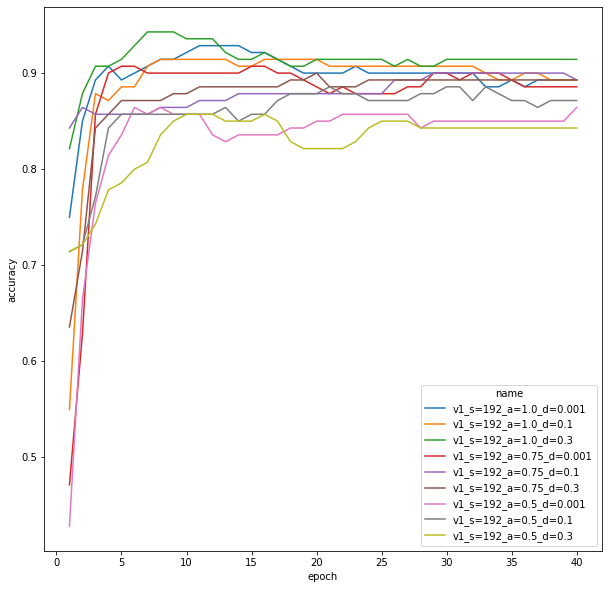

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'accuracy', data=history_192, hue='name')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


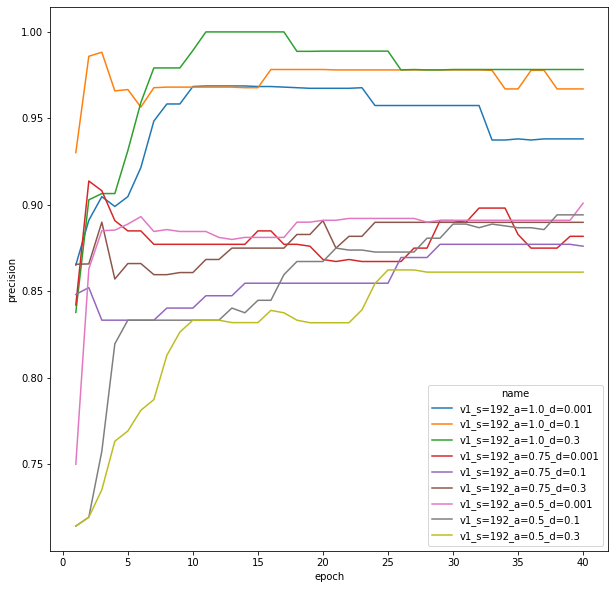

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'precision', data=history_192, hue='name')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


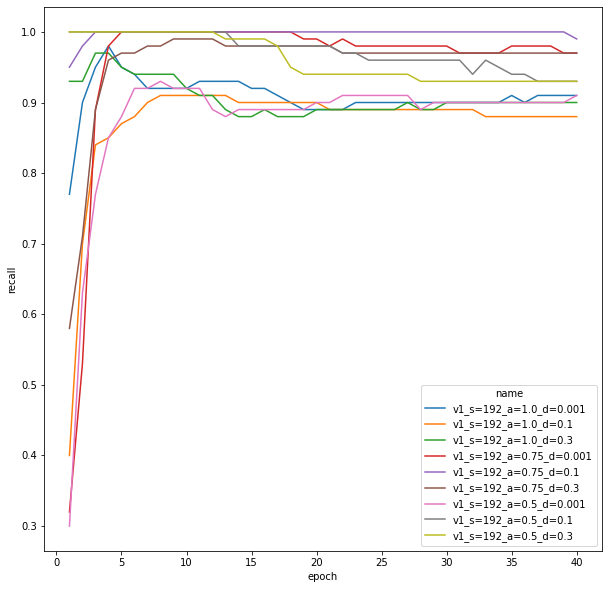

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'recall', data=history_192, hue='name')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


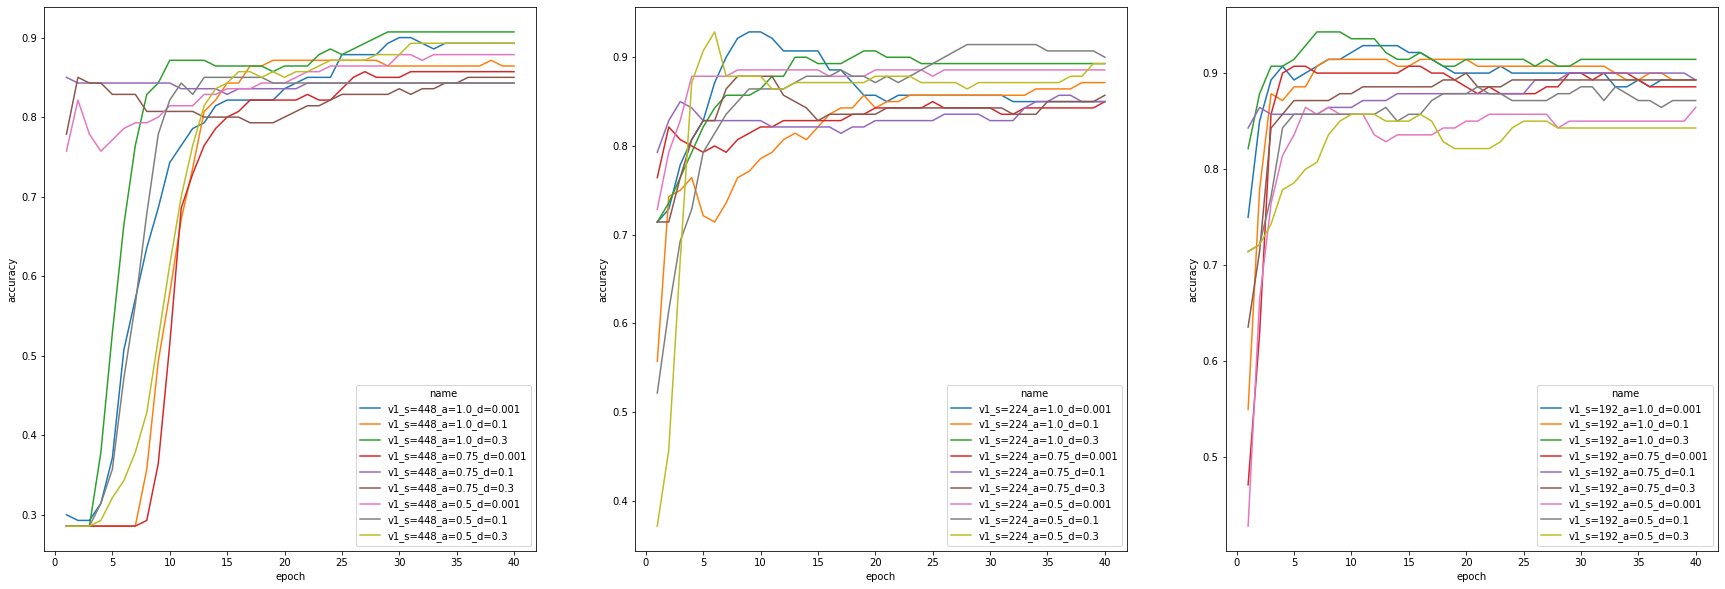

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(30, 10))

sns.lineplot('epoch', 'accuracy', data=history_448, hue='name', ax=ax[0])
sns.lineplot('epoch', 'accuracy', data=history_224, hue='name', ax=ax[1])
sns.lineplot('epoch', 'accuracy', data=history_192, hue='name', ax=ax[2])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


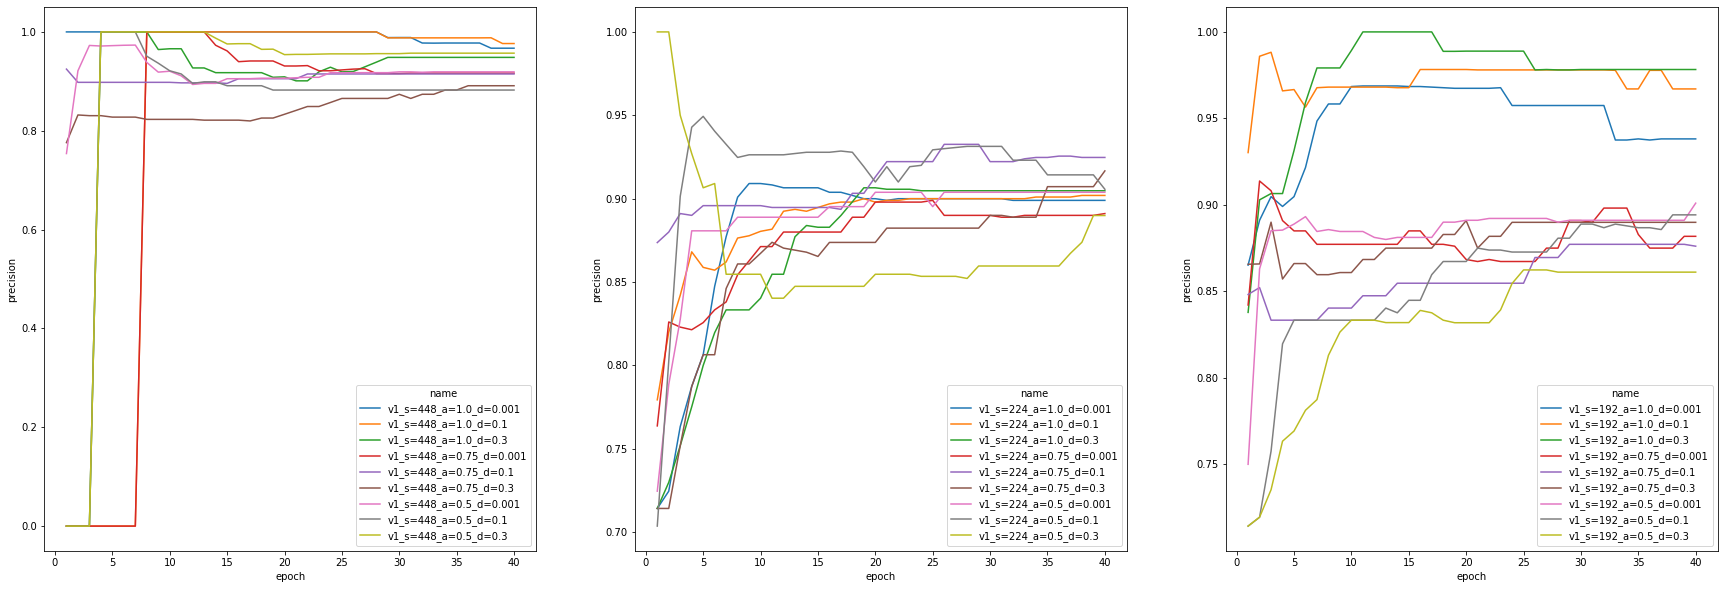

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(30, 10))

sns.lineplot('epoch', 'precision', data=history_448, hue='name', ax=ax[0])
sns.lineplot('epoch', 'precision', data=history_224, hue='name', ax=ax[1])
sns.lineplot('epoch', 'precision', data=history_192, hue='name', ax=ax[2])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


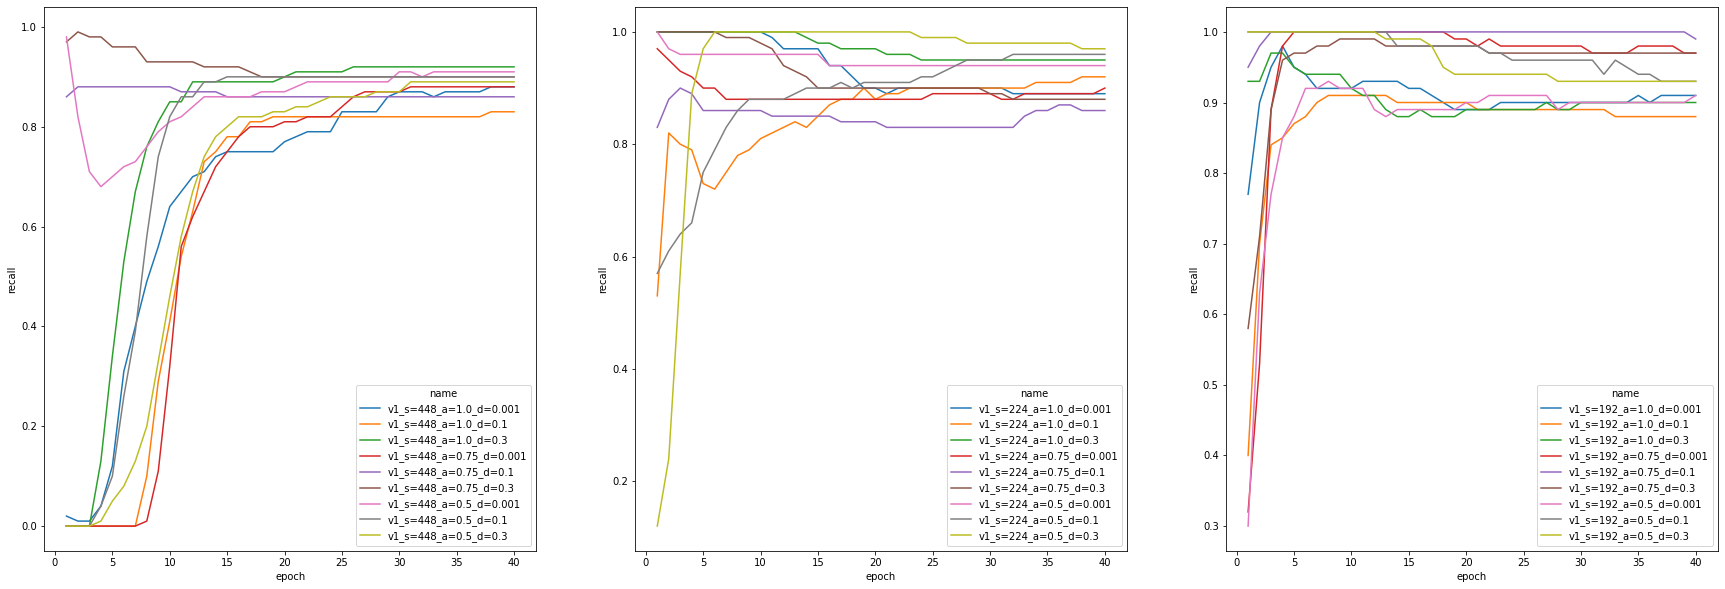

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(30, 10))

sns.lineplot('epoch', 'recall', data=history_448, hue='name', ax=ax[0])
sns.lineplot('epoch', 'recall', data=history_224, hue='name', ax=ax[1])
sns.lineplot('epoch', 'recall', data=history_192, hue='name', ax=ax[2])

In [ ]:
history_merged = pd.concat([history_448, history_224, history_192])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


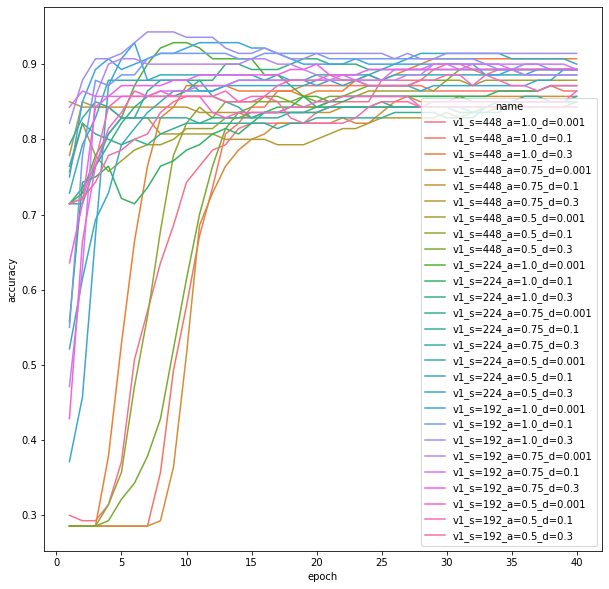

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'accuracy', data=history_merged, hue='name')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


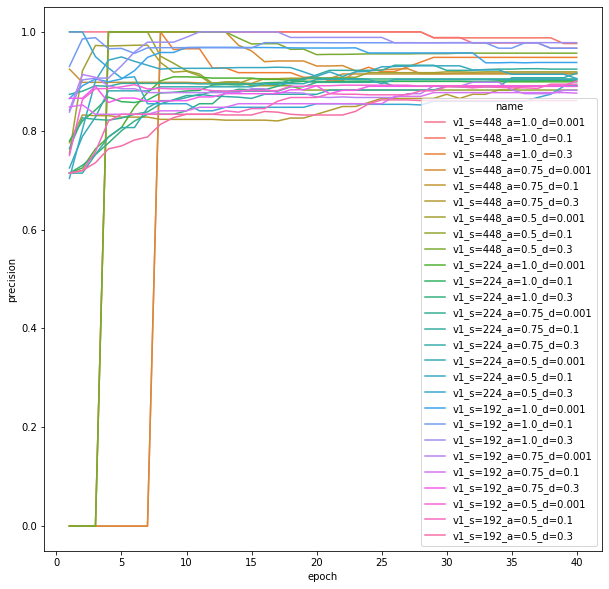

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'precision', data=history_merged, hue='name')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


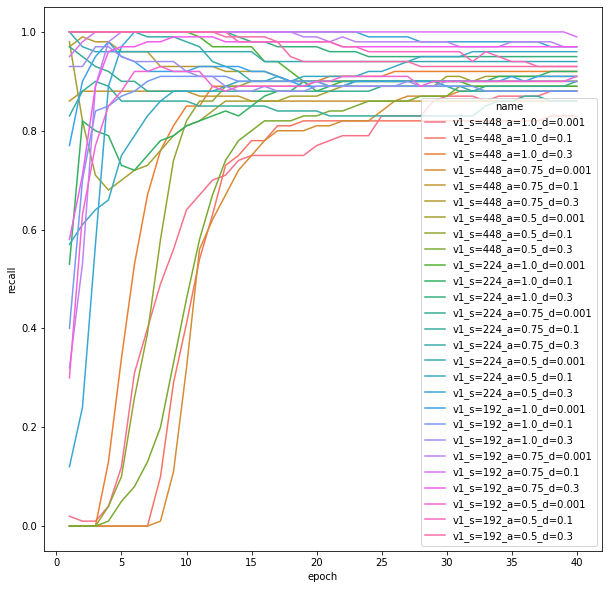

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'recall', data=history_merged, hue='name')

In [ ]:
history_merged = history_merged.sort_index()
history_merged.to_csv('history_merged.csv', header=True, index=False)

In [ ]:
history_merged[history_merged['epoch'] == 40].sort_values(by=['accuracy'], ascending=False)

,name,epoch,accuracy,precision,recall
279,v1_s=192_a=1.0_d=0.3,40,0.914286,0.978261,0.90
279,v1_s=448_a=1.0_d=0.3,40,0.907143,0.948454,0.92
79,v1_s=224_a=0.5_d=0.1,40,0.900000,0.905660,0.96
39,v1_s=448_a=0.5_d=0.3,40,0.892857,0.956989,0.89
159,v1_s=192_a=0.75_d=0.3,40,0.892857,0.889908,0.97
359,v1_s=192_a=1.0_d=0.001,40,0.892857,0.938144,0.91
319,v1_s=192_a=1.0_d=0.1,40,0.892857,0.967033,0.88
279,v1_s=224_a=1.0_d=0.3,40,0.892857,0.904762,0.95
199,v1_s=192_a=0.75_d=0.1,40,0.892857,0.876106,0.99
359,v1_s=448_a=1.0_d=0.001,40,0.892857,0.967033,0.88


In [ ]:
history_merged[history_merged['epoch'] == 40].sort_values(by=['precision'], ascending=False)

,name,epoch,accuracy,precision,recall
279,v1_s=192_a=1.0_d=0.3,40,0.914286,0.978261,0.90
319,v1_s=448_a=1.0_d=0.1,40,0.864286,0.976471,0.83
359,v1_s=448_a=1.0_d=0.001,40,0.892857,0.967033,0.88
319,v1_s=192_a=1.0_d=0.1,40,0.892857,0.967033,0.88
39,v1_s=448_a=0.5_d=0.3,40,0.892857,0.956989,0.89
279,v1_s=448_a=1.0_d=0.3,40,0.907143,0.948454,0.92
359,v1_s=192_a=1.0_d=0.001,40,0.892857,0.938144,0.91
199,v1_s=224_a=0.75_d=0.1,40,0.850000,0.924731,0.86
119,v1_s=448_a=0.5_d=0.001,40,0.878571,0.919192,0.91
159,v1_s=224_a=0.75_d=0.3,40,0.857143,0.916667,0.88


In [ ]:
history_merged[history_merged['epoch'] == 40].sort_values(by=['recall'], ascending=False)

,name,epoch,accuracy,precision,recall
199,v1_s=192_a=0.75_d=0.1,40,0.892857,0.876106,0.99
239,v1_s=192_a=0.75_d=0.001,40,0.885714,0.881818,0.97
159,v1_s=192_a=0.75_d=0.3,40,0.892857,0.889908,0.97
39,v1_s=224_a=0.5_d=0.3,40,0.892857,0.889908,0.97
79,v1_s=224_a=0.5_d=0.1,40,0.900000,0.905660,0.96
279,v1_s=224_a=1.0_d=0.3,40,0.892857,0.904762,0.95
119,v1_s=224_a=0.5_d=0.001,40,0.885714,0.903846,0.94
79,v1_s=192_a=0.5_d=0.1,40,0.871429,0.894231,0.93
39,v1_s=192_a=0.5_d=0.3,40,0.842857,0.861111,0.93
319,v1_s=224_a=1.0_d=0.1,40,0.871429,0.901961,0.92


In [ ]:
tf.saved_model.save(mobilenet_448,   'mobilenet_448')
tf.saved_model.save(mobilenet_448_2, 'mobilenet_448_2')
tf.saved_model.save(mobilenet_448_3, 'mobilenet_448_3')
tf.saved_model.save(mobilenet_448_4, 'mobilenet_448_4')
tf.saved_model.save(mobilenet_448_5, 'mobilenet_448_5')
tf.saved_model.save(mobilenet_448_6, 'mobilenet_448_6')
tf.saved_model.save(mobilenet_448_7, 'mobilenet_448_7')
tf.saved_model.save(mobilenet_448_8, 'mobilenet_448_8')
tf.saved_model.save(mobilenet_448_9, 'mobilenet_448_9')

tf.saved_model.save(mobilenet_224,   'mobilenet_224')
tf.saved_model.save(mobilenet_224_2, 'mobilenet_224_2')
tf.saved_model.save(mobilenet_224_3, 'mobilenet_224_3')
tf.saved_model.save(mobilenet_224_4, 'mobilenet_224_4')
tf.saved_model.save(mobilenet_224_5, 'mobilenet_224_5')
tf.saved_model.save(mobilenet_224_6, 'mobilenet_224_6')
tf.saved_model.save(mobilenet_224_7, 'mobilenet_224_7')
tf.saved_model.save(mobilenet_224_8, 'mobilenet_224_8')
tf.saved_model.save(mobilenet_224_9, 'mobilenet_224_9')

tf.saved_model.save(mobilenet_192,   'mobilenet_192')
tf.saved_model.save(mobilenet_192_2, 'mobilenet_192_2')
tf.saved_model.save(mobilenet_192_3, 'mobilenet_192_3')
tf.saved_model.save(mobilenet_192_4, 'mobilenet_192_4')
tf.saved_model.save(mobilenet_192_5, 'mobilenet_192_5')
tf.saved_model.save(mobilenet_192_6, 'mobilenet_192_6')
tf.saved_model.save(mobilenet_192_7, 'mobilenet_192_7')
tf.saved_model.save(mobilenet_192_8, 'mobilenet_192_8')
tf.saved_model.save(mobilenet_192_9, 'mobilenet_192_9')

INFO:tensorflow:Assets written to: mobilenet_448/assets


INFO:tensorflow:Assets written to: mobilenet_448/assets


INFO:tensorflow:Assets written to: mobilenet_448_2/assets


INFO:tensorflow:Assets written to: mobilenet_448_2/assets


INFO:tensorflow:Assets written to: mobilenet_448_3/assets


INFO:tensorflow:Assets written to: mobilenet_448_3/assets


INFO:tensorflow:Assets written to: mobilenet_448_4/assets


INFO:tensorflow:Assets written to: mobilenet_448_4/assets


INFO:tensorflow:Assets written to: mobilenet_448_5/assets


INFO:tensorflow:Assets written to: mobilenet_448_5/assets


INFO:tensorflow:Assets written to: mobilenet_448_6/assets


INFO:tensorflow:Assets written to: mobilenet_448_6/assets


INFO:tensorflow:Assets written to: mobilenet_448_7/assets


INFO:tensorflow:Assets written to: mobilenet_448_7/assets


INFO:tensorflow:Assets written to: mobilenet_448_8/assets


INFO:tensorflow:Assets written to: mobilenet_448_8/assets


INFO:tensorflow:Assets written to: mobilenet_448_9/assets


INFO:tensorflow:Assets written to: mobilenet_448_9/assets


INFO:tensorflow:Assets written to: mobilenet_224/assets


INFO:tensorflow:Assets written to: mobilenet_224/assets


INFO:tensorflow:Assets written to: mobilenet_224_2/assets


INFO:tensorflow:Assets written to: mobilenet_224_2/assets


INFO:tensorflow:Assets written to: mobilenet_224_3/assets


INFO:tensorflow:Assets written to: mobilenet_224_3/assets


INFO:tensorflow:Assets written to: mobilenet_224_4/assets


INFO:tensorflow:Assets written to: mobilenet_224_4/assets


INFO:tensorflow:Assets written to: mobilenet_224_5/assets


INFO:tensorflow:Assets written to: mobilenet_224_5/assets


INFO:tensorflow:Assets written to: mobilenet_224_6/assets


INFO:tensorflow:Assets written to: mobilenet_224_6/assets


INFO:tensorflow:Assets written to: mobilenet_224_7/assets


INFO:tensorflow:Assets written to: mobilenet_224_7/assets


INFO:tensorflow:Assets written to: mobilenet_224_8/assets


INFO:tensorflow:Assets written to: mobilenet_224_8/assets


INFO:tensorflow:Assets written to: mobilenet_224_9/assets


INFO:tensorflow:Assets written to: mobilenet_224_9/assets


INFO:tensorflow:Assets written to: mobilenet_192/assets


INFO:tensorflow:Assets written to: mobilenet_192/assets


INFO:tensorflow:Assets written to: mobilenet_192_2/assets


INFO:tensorflow:Assets written to: mobilenet_192_2/assets


INFO:tensorflow:Assets written to: mobilenet_192_3/assets


INFO:tensorflow:Assets written to: mobilenet_192_3/assets


INFO:tensorflow:Assets written to: mobilenet_192_4/assets


INFO:tensorflow:Assets written to: mobilenet_192_4/assets


INFO:tensorflow:Assets written to: mobilenet_192_5/assets


INFO:tensorflow:Assets written to: mobilenet_192_5/assets


INFO:tensorflow:Assets written to: mobilenet_192_6/assets


INFO:tensorflow:Assets written to: mobilenet_192_6/assets


INFO:tensorflow:Assets written to: mobilenet_192_7/assets


INFO:tensorflow:Assets written to: mobilenet_192_7/assets


INFO:tensorflow:Assets written to: mobilenet_192_8/assets


INFO:tensorflow:Assets written to: mobilenet_192_8/assets


INFO:tensorflow:Assets written to: mobilenet_192_9/assets


INFO:tensorflow:Assets written to: mobilenet_192_9/assets


In [ ]:
import glob
for p in glob.glob('mobilenet*'):
  converter = tf.lite.TFLiteConverter.from_saved_model(p)
  tflite_model = converter.convert()

  with open(p + '.tflite', 'wb') as f:
    f.write(tflite_model)